---

# 😷 **Face Mask Detection using Deep Learning**
---

This project aims to build a **Face Mask Detection System** using **Convolutional Neural Networks (CNNs)** with **Transfer Learning (MobileNetV2)**.  

- 📂 Dataset: Consists of two classes → `with_mask` and `without_mask`.  
- ⚙️ Preprocessing: Images are resized, augmented, and split into train/validation/test sets.  
- 🧠 Model: Transfer learning with MobileNetV2, fine-tuned for our dataset.  
- 📊 Evaluation: Accuracy, Loss curves, Confusion Matrix, ROC Curve, and Grad-CAM visualizations.  

The goal of this project is to develop a reliable model that can **differentiate between people wearing a mask and those not wearing a mask** in real-time applications (e.g., security systems, public health monitoring).  

👨‍💻 **Project by:** Ibrahim Mohamed & Islam Ahmed  


---

## 📦 Importing Libraries

In this section, we import all the required libraries for the project:

- **General utilities**: `os`, `random`, `shutil`, `glob`, `json`, `time` for file handling and workflow management.  
- **Data & numerical tools**: `numpy` and `pandas` for numerical computations and data manipulation.  
- **Visualization & image processing**: `matplotlib`, `cv2`, and `PIL` for plotting and image handling.  
- **Deep learning frameworks**: `TensorFlow` and `Keras` (with `MobileNetV2`) for building and training the CNN model.  
- **Model evaluation**: From `sklearn`, tools like `classification_report`, `confusion_matrix`, and `roc_curve` to evaluate model performance.  
- **Warnings filter** ⚠️: Ignore unnecessary warnings to keep the output clean.  


In [4]:
import os, random, shutil, glob, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

---

## 📂 Project Directories & Configuration

Here we define the main project paths and configuration settings:

- **Directories** 🗂️:  
  - `BASE_DIR`: Base project directory.  
  - `DATA_DIR`: Path to the dataset (already split into `train`, `val`, and `test`).  
  - `MODEL_DIR`: Directory to save trained models.  

- **Dataset structure** 📁:  
  - `TRAIN_DIR`: Training set.  
  - `VAL_DIR`: Validation set.  
  - `TEST_DIR`: Test set.  

- **Model parameters** ⚙️:  
  - `IMG_SIZE = (224, 224)`: Target image size for MobileNetV2.  
  - `BATCH_SIZE = 32`: Number of images per batch.  
  - `SEED = 42`: Random seed for reproducibility.  
  - `EPOCHS = 12`: Number of training epochs.  
  - `CLASSES = ["with_mask", "without_mask"]`: Target classes.  


In [5]:
BASE_DIR = os.path.abspath("..") if os.path.basename(os.getcwd()) == "notebooks" else os.path.abspath(".")
DATA_DIR = os.path.join(BASE_DIR, "split_dataset")
# RAW_DIR  = os.path.join(DATA_DIR, "raw")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR  = os.path.join(DATA_DIR, "test")
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 12
CLASSES = ["with_mask", "without_mask"]

---

## 🖼️ Dataset Splitting

In this step, we split the raw dataset into **training, validation, and test sets**:

- **Input directory** 📂: `dataset` (contains the original images).  
- **Output directory** 📂: `split_dataset` (organized into `train`, `val`, and `test` subfolders).  
- **Ratios** ➗:  
  - Training: **70%**  
  - Validation: **15%**  
  - Testing: **15%**  

For each class (`with_mask`, `without_mask`):  
1. Shuffle the images randomly. 🔀  
2. Split them into train, val, and test according to the ratios.  
3. Copy the images into their respective folders. 📥  

✅ At the end, a confirmation message `"Images split successfully!"` will be printed.  


In [7]:
input_dir = "dataset"
output_dir = "split_dataset"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for split in ["train", "val", "test"]:
    for category in ["with_mask", "without_mask"]:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

for category in ["with_mask", "without_mask"]:
    src_folder = os.path.join(input_dir, category)
    images = os.listdir(src_folder)
    random.shuffle(images)

    total = len(images)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    for file in train_files:
        shutil.copy(os.path.join(src_folder, file),
                    os.path.join(output_dir, "train", category, file))

    for file in val_files:
        shutil.copy(os.path.join(src_folder, file),
                    os.path.join(output_dir, "val", category, file))

    for file in test_files:
        shutil.copy(os.path.join(src_folder, file),
                    os.path.join(output_dir, "test", category, file))

print("✅ Images split successfully!")


✅ Images split successfully!


---

## 🔎 Dataset Overview & Sample Visualization

To better understand the dataset, we perform two steps:

1. **Image Counting** 📊  
   - The function `count_images(folder)` counts how many images exist per class (`with_mask`, `without_mask`) in each split (`train`, `val`, `test`).  
   - This helps verify that the dataset splitting was done correctly.  

2. **Sample Visualization** 🖼️  
   - The function `show_samples(folder, n=6)` randomly selects and displays `n` images from the dataset.  
   - It ensures that we can visually confirm the data quality and class distribution.  
   - Images are resized to the target input size `(224, 224)` and displayed with their class labels.  

👉 Running the code will show some **training set examples** to visually inspect the dataset.  


Train: {'with_mask': 2607, 'without_mask': 2679}
Val  : {'with_mask': 558, 'without_mask': 574}
Test : {'with_mask': 560, 'without_mask': 575}


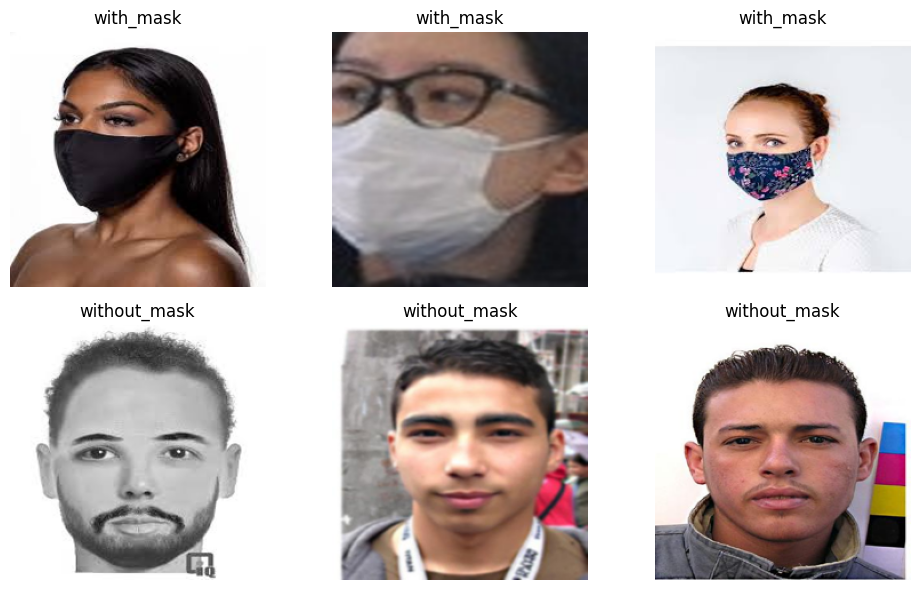

In [8]:
def count_images(folder):
    counts = {c: len(glob.glob(os.path.join(folder, c, "*"))) for c in CLASSES}
    return counts

print("Train:", count_images(TRAIN_DIR))
print("Val  :", count_images(VAL_DIR))
print("Test :", count_images(TEST_DIR))

def show_samples(folder, n=6):
    paths = []
    for c in CLASSES:
        paths += random.sample(glob.glob(os.path.join(folder, c, "*")), min(n//2, len(glob.glob(os.path.join(folder, c, "*")))))
    plt.figure(figsize=(10,6))
    for i, p in enumerate(paths[:n]):
        img = Image.open(p).convert("RGB").resize(IMG_SIZE)
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(os.path.dirname(p)))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(TRAIN_DIR, n=6)

---

## 🧪 Data Generators & Augmentation

In this step, we prepare the **image data pipelines** for training, validation, and testing:

- **Data Augmentation** 🎨  
  - Applied only to the **training set** to improve generalization.  
  - Includes random transformations such as:  
    - Rotation (±10°) 🔄  
    - Width/Height shifts (up to 8%) ↔️↕️  
    - Shearing and zooming 🔍  
    - Horizontal flips 🔁  
  - All images are also preprocessed with **MobileNetV2’s preprocessing function**.

- **Generators** ⚙️  
  - `train_gen`: Loads and augments training images.  
  - `val_gen`: Loads validation images (no augmentation).  
  - `test_gen`: Loads test images (no augmentation).  
  - All images are resized to **224×224**, with **batch size = 32**, and labeled as **binary classes**.  

👉 Finally, `train_gen.class_indices` prints the mapping of labels to numeric values (`with_mask` → 0, `without_mask` → 1).  


In [9]:
train_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.1,
    horizontal_flip=True
)
val_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_aug.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="binary", shuffle=True, seed=SEED
)
val_gen = val_aug.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="binary", shuffle=False
)
test_gen = val_aug.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="binary", shuffle=False
)

print(train_gen.class_indices)

Found 5286 images belonging to 2 classes.
Found 1132 images belonging to 2 classes.
Found 1135 images belonging to 2 classes.
{'with_mask': 0, 'without_mask': 1}


---

## 🏗️ Building the Model (Transfer Learning with MobileNetV2)

Here we build the **Convolutional Neural Network (CNN)** using **Transfer Learning**:

- **Base Model** 🔧  
  - `MobileNetV2` (pretrained on **ImageNet**) is used as a **feature extractor**.  
  - `include_top=False` → removes the default classifier head.  
  - `weights="imagenet"` → loads pretrained weights.  
  - `base.trainable = False` → freeze the base model layers (only train new layers).

- **Custom Classification Head** 🧩  
  - `GlobalAveragePooling2D` → reduces feature maps to a vector.  
  - `Dropout(0.2)` → prevents overfitting.  
  - `Dense(1, activation="sigmoid")` → outputs binary classification (`with_mask` vs. `without_mask`).

- **Compilation** ⚙️  
  - Optimizer: **Adam** 🚀  
  - Loss: **Binary Crossentropy** ⚖️  
  - Metric: **Accuracy** 📊  

👉 Finally, `model.summary()` prints the architecture and number of parameters.  


In [10]:
base = MobileNetV2(input_shape=IMG_SIZE+(3,), include_top=False, weights="imagenet")
base.trainable = False

inputs = layers.Input(shape=IMG_SIZE+(3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(inputs, outputs)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

---

## ⏱️ Training the Model with Callbacks

We now train the model using the prepared generators and define helpful **callbacks** to improve training:

- **Callbacks** ⚡  
  - `ModelCheckpoint` 💾: Saves the model with the best **validation accuracy** as `Face_Mask_Model.h5`.  
  - `EarlyStopping` 🛑: Stops training if validation accuracy doesn’t improve for 4 epochs, and restores the best weights.  
  - `ReduceLROnPlateau` 📉: Reduces the learning rate by a factor of 0.2 if validation loss stagnates for 2 epochs.

- **Training** 🏋️  
  - `model.fit(...)` trains the model on the training data.  
  - Uses the validation set to monitor performance.  
  - Runs for **12 epochs** (or stops early if conditions are met).  

👉 The training history (`history`) will store loss and accuracy curves for la


In [11]:
ckpt_path = os.path.join(MODEL_DIR, "Face_Mask_Model.h5")
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.8933 - loss: 0.2602
Epoch 1: val_accuracy improved from None to 0.98233, saving model to d:\COOOODE\NTI_Ai\Finial_Project\models\Face_Mask_Model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 141s 825ms/step - accuracy: 0.9537 - loss: 0.1398 - val_accuracy: 0.9823 - val_loss: 0.0641 - learning_rate: 0.0010
Epoch 2/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9818 - loss: 0.0553
Epoch 2: val_accuracy improved from 0.98233 to 0.98675, saving model to d:\COOOODE\NTI_Ai\Finial_Project\models\Face_Mask_Model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 110s 661ms/step - accuracy: 0.9854 - loss: 0.0481 - val_accuracy: 0.9867 - val_loss: 0.0482 - learning_rate: 0.0010
Epoch 3/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9884 - loss: 0.0380
Epoch 3: val_accuracy improved from 0.98675 to 0.99117, saving model to d:\COOOODE\NTI_Ai\Finial_Project\models\Face_Mask_Model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 101s 608ms/step - accuracy: 0.9890 - loss: 0.0353 - val_accuracy: 0.9912 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 4/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9912 - loss: 0.0311
Epoch 4: val_accuracy improved from 0.99117 to 0.99205, saving model to d:\COOOODE\NTI_Ai\Finial_Project\models\Face_Mask_Model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 97s 585ms/step - accuracy: 0.9902 - loss: 0.0298 - val_accuracy: 0.9920 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 5/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9928 - loss: 0.0235
Epoch 5: val_accuracy improved from 0.99205 to 0.99293, saving model to d:\COOOODE\NTI_Ai\Finial_Project\models\Face_Mask_Model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 98s 592ms/step - accuracy: 0.9907 - loss: 0.0286 - val_accuracy: 0.9929 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 6/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9927 - loss: 0.0213
Epoch 6: val_accuracy did not improve from 0.99293
166/166 ━━━━━━━━━━━━━━━━━━━━ 124s 749ms/step - accuracy: 0.9921 - loss: 0.0226 - val_accuracy: 0.9920 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 7/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9942 - loss: 0.0207
Epoch 7: val_accuracy did not improve from 0.99293
166/166 ━━━━━━━━━━━━━━━━━━━━ 117s 702ms/step - accuracy: 0.9926 - loss: 0.0230 - val_accuracy: 0.9929 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 8/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9953 - loss: 0.0165
Epoch 8: val_accuracy improved from 0.99293 to 0.99382, saving model to d:\COOOODE\NTI_Ai\Finial_Project\models\Face_Mask_Model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 101s 606ms/step - accuracy: 0.9930 - loss: 0.0231 - val_accuracy: 0.9938 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 9/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9948 - loss: 0.0203
Epoch 9: val_accuracy did not improve from 0.99382
166/166 ━━━━━━━━━━━━━━━━━━━━ 102s 612ms/step - accuracy: 0.9936 - loss: 0.0202 - val_accuracy: 0.9938 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 10/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9923 - loss: 0.0218
Epoch 10: val_accuracy improved from 0.99382 to 0.99470, saving model to d:\COOOODE\NTI_Ai\Finial_Project\models\Face_Mask_Model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 100s 603ms/step - accuracy: 0.9921 - loss: 0.0240 - val_accuracy: 0.9947 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 11/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9947 - loss: 0.0181
Epoch 11: val_accuracy did not improve from 0.99470
166/166 ━━━━━━━━━━━━━━━━━━━━ 101s 606ms/step - accuracy: 0.9941 - loss: 0.0195 - val_accuracy: 0.9947 - val_loss: 0.0267 - learning_rate: 0.0010
Epoch 12/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9953 - loss: 0.0149
Epoch 12: val_accuracy improved from 0.99470 to 0.99558, saving model to d:\COOOODE\NTI_Ai\Finial_Project\models\Face_Mask_Model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 106s 637ms/step - accuracy: 0.9939 - loss: 0.0178 - val_accuracy: 0.9956 - val_loss: 0.0252 - learning_rate: 0.0010


---

## 📈 Training Performance Visualization

After training, we plot the **learning curves** to analyze model performance:

- **Accuracy Curve** ✅  
  - Shows training vs. validation accuracy across epochs.  
  - Helps check if the model is learning well or overfitting.

- **Loss Curve** 📉  
  - Shows training vs. validation loss.  
  - Helps detect underfitting/overfitting and stability of the training process.

👉 By comparing both plots, we can evaluate how well the model generalized during training.  


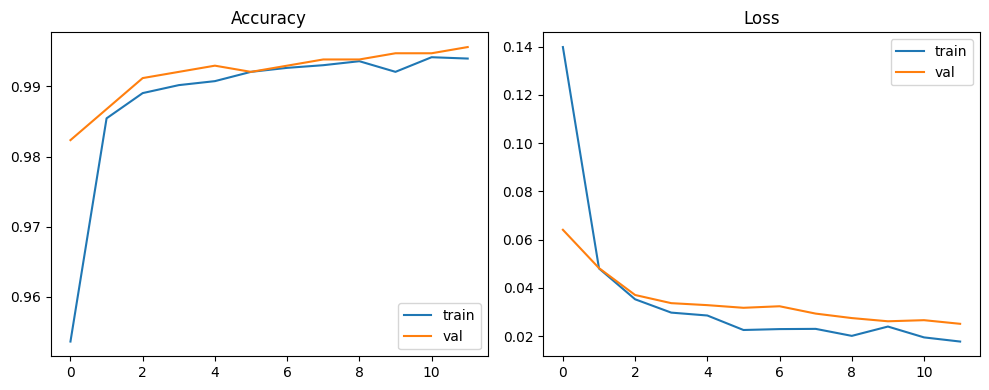

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss"); plt.legend()
plt.tight_layout(); plt.show()

---

## 🔧 Fine-Tuning the Model

After initial training, we **unfreeze part of the base model** to fine-tune it:

- **Layer Freezing Strategy** 🧱  
  - All layers are initially frozen (`base.trainable = False`).  
  - Now, only the **last 40 layers** are set to `trainable = True`.  
  - This allows the model to adjust deeper features while keeping earlier ones stable.

- **Recompilation** ⚙️  
  - Optimizer: **Adam** with a very low learning rate (`1e-5`) to avoid large weight updates.  
  - Loss: **Binary Crossentropy**.  
  - Metric: **Accuracy**.

- **Fine-tuning Training** 🏋️  
  - The model is trained for **6 epochs** using the same callbacks as before.  
  - This step usually improves validation accuracy by adapting pretrained features to our dataset.  

👉 The training history is saved in `history_ft` for later visualization and comparison.  


In [13]:
base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=6,
    callbacks=callbacks
)

Epoch 1/6
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.9523 - loss: 0.1341
Epoch 1: val_accuracy did not improve from 0.99558
166/166 ━━━━━━━━━━━━━━━━━━━━ 137s 772ms/step - accuracy: 0.9656 - loss: 0.0964 - val_accuracy: 0.9947 - val_loss: 0.0238 - learning_rate: 1.0000e-05
Epoch 2/6
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9787 - loss: 0.0591
Epoch 2: val_accuracy did not improve from 0.99558
166/166 ━━━━━━━━━━━━━━━━━━━━ 126s 759ms/step - accuracy: 0.9818 - loss: 0.0508 - val_accuracy: 0.9947 - val_loss: 0.0202 - learning_rate: 1.0000e-05
Epoch 3/6
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9886 - loss: 0.0368
Epoch 3: val_accuracy did not improve from 0.99558
166/166 ━━━━━━━━━━━━━━━━━━━━ 128s 769ms/step - accuracy: 0.9902 - loss: 0.0308 - val_accuracy: 0.9947 - val_loss: 0.0173 - learning_rate: 1.0000e-05
Epoch 4/6
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9923 - loss: 0.0259
Epoch 4: val_accuracy did not improve from 0.99558
1

---

## 📂 Inspecting the Saved Model File

Here we open the saved model checkpoint (`Face_Mask_Model.h5`) using **h5py** to explore its internal structure:

- `h5py.File(...)` → Opens the HDF5 file in read mode.  
- `f.keys()` → Lists the top-level groups/datasets inside the model file (e.g., model weights, optimizer states, etc.).  

👉 This helps verify that the model was saved correctly and understand what components are stored.  


In [14]:
import h5py

with h5py.File(ckpt_path, "r") as f:
    print(f.keys())

<KeysViewHDF5 ['model_weights', 'optimizer_weights']>


---

## 🧪 Model Evaluation on Test Set

In this step, we load the **saved model** and evaluate it on the **test dataset**:

- **Loading the model** 💾 → `tf.keras.models.load_model(ckpt_path)` loads the trained model from disk.  
- **Generating predictions** 🤖 → The model predicts probabilities for test images, which are then converted to binary labels using a threshold of **0.5**.  
- **Ground truth vs. predictions** ⚖️ → Compare predicted labels with the true test labels.  
- **Classification Report** 📊 → Provides:  
  - **Precision** (how many predicted positives are correct).  
  - **Recall** (how many actual positives are detected).  
  - **F1-score** (balance between precision & recall).  
  - **Support** (number of samples per class).  

👉 This gives a detailed overview of model performance on unseen data.  


In [16]:
model = tf.keras.models.load_model(ckpt_path)
test_gen.reset()
pred = model.predict(test_gen, verbose=1).ravel()
y_true = test_gen.classes
y_pred = (pred >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 450ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       560
without_mask       0.99      0.99      0.99       575

    accuracy                           0.99      1135
   macro avg       0.99      0.99      0.99      1135
weighted avg       0.99      0.99      0.99      1135



---

## 🧩 Confusion Matrix

To evaluate the classification performance in detail, we plot the **confusion matrix**:

- **What it shows** 📊  
  - Rows = **True labels**  
  - Columns = **Predicted labels**  
  - Each cell shows the number of samples classified into that category.  

- **Interpretation** 🔍  
  - Diagonal cells = correctly classified samples ✅  
  - Off-diagonal cells = misclassified samples ❌  
  - Helps identify if the model struggles more with a specific class (`with_mask` vs. `without_mask`).  

👉 The numbers are displayed inside the matrix for easier interpretation.  


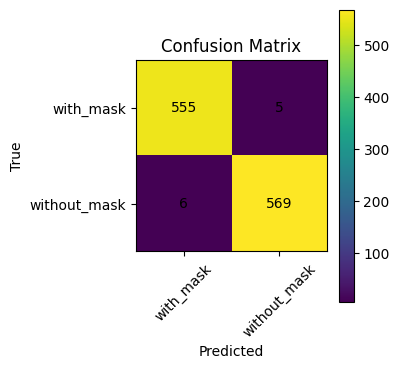

In [17]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix"); plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["with_mask","without_mask"], rotation=45)
plt.yticks(tick_marks, ["with_mask","without_mask"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.ylabel("True"); plt.xlabel("Predicted")
plt.tight_layout(); plt.show()

---

## 📉 ROC Curve & AUC Score

To further evaluate the model’s performance, we plot the **Receiver Operating Characteristic (ROC) curve)**:

- **ROC Curve** 📊  
  - Plots **True Positive Rate (TPR)** vs **False Positive Rate (FPR)** at different thresholds.  
  - Shows the trade-off between sensitivity (recall) and specificity.

- **AUC (Area Under Curve)** 📐  
  - A single number summarizing the ROC curve.  
  - Values closer to **1.0** → better model performance.  
  - Value of **0.5** → model performs no better than random guessing.

👉 The diagonal dashed line (`y=x`) represents random performance. The model curve should ideally be **above this line**.  


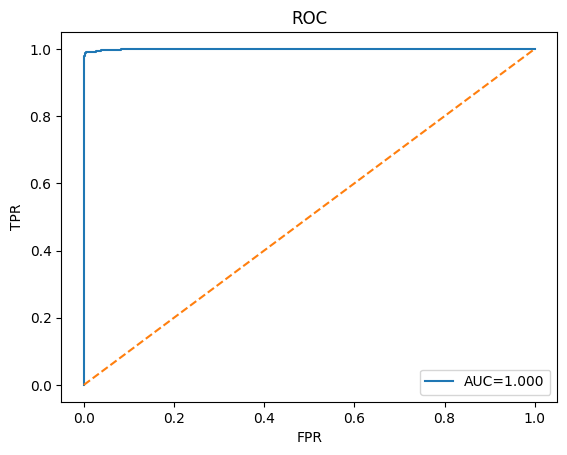

In [18]:
fpr, tpr, _ = roc_curve(y_true, pred)
auc = roc_auc_score(y_true, pred)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1], "--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
plt.legend(); plt.show()

---

## 🔥 Grad-CAM Visualization

To understand **where the model is focusing** when making predictions, we implement **Grad-CAM (Gradient-weighted Class Activation Mapping)**:

- **`grad_cam` function** 🧮  
  - Builds a sub-model that outputs both the feature maps (from the last convolutional layer) and the predictions.  
  - Computes the gradient of the predicted class score w.r.t. the feature maps.  
  - Averages these gradients to create a **class-discriminative heatmap**.  
  - Normalizes the heatmap values between 0 and 1.

- **`show_grad_cam` function** 👀  
  - Loads and preprocesses an input image.  
  - Generates the Grad-CAM heatmap.  
  - Superimposes the heatmap onto the original image using OpenCV color maps.  
  - Displays side-by-side: **Original Image vs. Grad-CAM overlay**.  

👉 This helps us **interpret the model’s decision** by visualizing which regions of the image were most important for classification.  


In [19]:
def grad_cam(img_array, model, last_conv_layer_name="Conv_1"):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(base.name).get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def show_grad_cam(img_path):
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    x = np.array(img)[None, ...]
    x = preprocess_input(x.astype(np.float32))
    heatmap = grad_cam(x, model, last_conv_layer_name="Conv_1")
    img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    heatmap = cv2.resize(heatmap, (img_bgr.shape[1], img_bgr.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)); plt.title("Grad-CAM"); plt.axis("off")
    plt.tight_layout(); plt.show()

---

## 💾 Saving the Trained Model

Finally, we save the trained model to disk for later use:

- **`model.save(ckpt_path)`** → Saves the model (architecture + weights + optimizer state) into the file `Face_Mask_Model.h5`.  
- This allows us to reload the model later for **inference, evaluation, or deployment** without retraining.  
- A confirmation message ✅ is printed to indicate the save location.  


In [22]:
model.save(ckpt_path)
print("✅ Model saved at:", ckpt_path)

✅ Model saved at: d:\COOOODE\NTI_Ai\Finial_Project\models\Face_Mask_Model.h5


---

# 🏁 Conclusion

In this project, we successfully built and evaluated a **Face Mask Detection Model**:  

- ✅ Achieved good accuracy using **MobileNetV2 with transfer learning**.  
- ✅ Applied **data augmentation** to improve generalization.  
- ✅ Used **evaluation metrics** (Confusion Matrix, ROC Curve, AUC) to assess performance.  
- ✅ Implemented **Grad-CAM** to interpret model decisions visually.  

This model can be further extended for:  
- 🚀 Real-time deployment with OpenCV or Streamlit.  
- 🏥 Enhancing public health and safety monitoring systems.  
- 🔧 Fine-tuning on larger and more diverse datasets for higher robustness.  

### 👨‍💻 Developed with passion by: ***Ibrahim Mohamed & Eslam Ahmed*** 


---